# Quantum Randomized Benchmarking

### 参考资料

- [Randomized Benchmarking](https://qiskit.org/textbook/ch-quantum-hardware/randomized-benchmarking.html)

In [4]:
# Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Import the RB Functions
# import qiskit.ignis.verification.randomized_benchmarking as rb
import qiskit_experiments.library.randomized_benchmarking as rb

# Import Qiskit classes 
import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

### Step 1: Generate RB sequences 


In [5]:
# Generate RB circuits (2Q RB)

# number of qubits
nQ = 2 
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
# Number of seeds (random sequences)
rb_opts['nseeds'] = 5
# Default pattern
rb_opts['rb_pattern'] = [[0, 1]]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

AttributeError: module 'qiskit_experiments.library.randomized_benchmarking' has no attribute 'randomized_benchmarking_seq'

作为例子，我们打印第一个RB序列对应的电路


In [6]:
#查看RB序列
rb_circs[0][0].draw()


NameError: name 'rb_circs' is not defined

我们可以验证代表每个 RB 电路的酉元应该是同一的（具有全局相位）。我们使用 Aer 模拟器来模拟这一点。


In [ ]:
# Create a new circuit without the measurement
qregs = rb_circs[0][-1].qregs
cregs = rb_circs[0][-1].cregs
qc = qiskit.QuantumCircuit(*qregs, *cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc.data.append(i)

In [ ]:
# The Unitary is an identity (with a global phase)
sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
qc.save_unitary()
unitary = sim.run(qc).result().get_unitary()
from qiskit.visualization import array_to_latex
array_to_latex(unitary, prefix="\\text{Unitary} = ")

### Step 2: Execute the RB sequences (with some noise) 

我们可以使用 Qiskit Aer Simulator（带有一些噪声模型）或使用 IBMQ 提供程序来执行 RB 序列，并获得结果列表。


In [ ]:
# Run on a noisy simulator
noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
p1Q = 0.002
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

backend = qiskit.Aer.get_backend('aer_simulator')

### Step 3: Get statistics about the survival probabilities 


测量序列

在实际中，我们通过测量量子态为基态，或者测量独立的量子比特。

### Step 4: Find the averaged sequence fidelity 


### Step 5: Fit the results 


the average error-rate r , which is also called Error per Clifford (EPC) according to the relation：
$$ r= 1-\alpha-\frac{1-\alpha}{2^n} = \frac{2^n-1}{2^n}(1-\alpha)$$

作为示例，我们计算每个 RB 序列的平均序列保真度，将结果拟合到指数曲线，并计算参数


In [ ]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
for rb_seed, rb_circ_seed in enumerate(rb_circs):
    print(f'Compiling seed {rb_seed}')
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    print(f'Simulating seed {rb_seed}')
    qobj = assemble(new_rb_circ_seed, shots=shots)
    job = backend.run(qobj,
                      noise_model=noise_model,
                      max_parallel_experiments=0)
    # Add data to the fitter
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

### Extra Step: Plot the results 


NameError: name 'rb_fit' is not defined

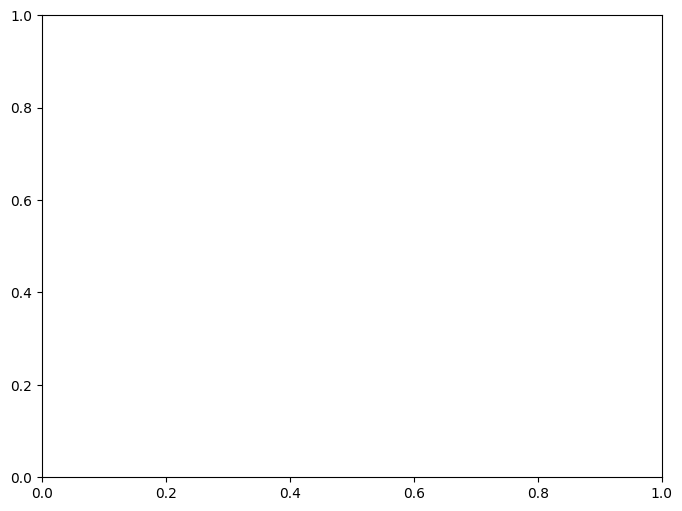

In [7]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

plt.show()

## 3. The Intuition Behind RB

事实证明，如果门是均匀随机的克利福德门，那么每个门的噪声平均表现为去极化通道，并且有一些参数可以从通道中计算出来。

## 4. Simultaneous Randomized Benchmarking 

参考:

Jay M. Gambetta, A. D. C´orcoles, S. T. Merkel, B. R. Johnson, John A. Smolin, Jerry M. Chow, Colm A. Ryan, Chad Rigetti, S. Poletto, Thomas A. Ohki, Mark B. Ketchen, and M. Steffen, Characterization of addressability by simultaneous randomized benchmarking, https://arxiv.org/pdf/1204.6308



## 5. Predicted Gate Fidelity 


参考：
David C. McKay, Sarah Sheldon, John A. Smolin, Jerry M. Chow, and Jay M. Gambetta, Three Qubit Randomized Benchmarking, https://arxiv.org/pdf/1712.06550



## 其他参考文献

Easwar Magesan, J. M. Gambetta, and Joseph Emerson, Robust randomized benchmarking of quantum processes, https://arxiv.org/pdf/1009.3639

Easwar Magesan, Jay M. Gambetta, and Joseph Emerson, Characterizing Quantum Gates via Randomized Benchmarking, https://arxiv.org/pdf/1109.6887

A. D. C'orcoles, Jay M. Gambetta, Jerry M. Chow, John A. Smolin, Matthew Ware, J. D. Strand, B. L. T. Plourde, and M. Steffen, Process verification of two-qubit quantum gates by randomized benchmarking, https://arxiv.org/pdf/1210.7011